# Objective:

Classify Amazon food reviews using Gradient Boosted Decision Trees.

We'll do the following exercises in this notebook

* Load and standardize the data in the format
        1. BoW
        2. Tfidf
        3. Avg. W2V
        4. Tfidf weighted W2V
* Divide the data in cross validation sets and find the optimal parameters n_estimators and max_depth using GridSearchCV
* Plot the Cross Validation score for each combination of the above parameters
* Plot confusion matrix and calculate Precision, Recall, FPR, TNR, FNR. 



In [1]:
# To suprress the warnings as they make the notebook less presentable.

import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

Import the necessary libraries. I'll be using the **XGBClassifier** from the library **xgboost** with the parameter *booster* = 'gbtree'.

Thankfully xgboost offers an API which is consistent with that of sklearn. This means we can use it with GridSearch the same way we use algorithms natively implemented in sklearn. The reason for not using sklearn's implementation of GBDT is that xgboost is faster and it is specifically designed for *boosting* algorithms. 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score, precision_score, confusion_matrix, accuracy_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import pickle
import numpy as np
from sklearn.svm import SVC
from xgboost import XGBClassifier

This Jupyter notebook extension notifies you when a cell finishes its execution!

In [3]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

## Important parameters of GBDT

* *n_estimators* : This parameter specifies how many base learners to use. Generally, more the number of estimators, better the results.
* *max_depth* : This determines how deep the decision trees will be built.

Load the target variable y of train and test sets. Note that the entire dataset is being used. All 350k reviews. The dataset is divided into train and test with ratio 80:20 respectively.

In [4]:
# f = open(r'D:\data_science\datasets\amazon2\y_train_full80_20.pkl', 'rb')
f = open('/home/ucanreachtvk/data/y_train_full80_20.pkl', 'rb')
y_train = pickle.load(f)
f.close()
print('The datatype of y_train is : {}'.format(type(y_train)))
print('The shape of y_train is : {}'.format(y_train.shape))

The datatype of y_train is : <class 'numpy.ndarray'>
The shape of y_train is : (291336,)


In [5]:
#f = open(r'D:\data_science\datasets\amazon2\y_test_full80_20.pkl', 'rb')
f = open('/home/ucanreachtvk/data/y_test_full80_20.pkl', 'rb')
y_test = pickle.load(f)
f.close()
print('The datatype of y_test is : {}'.format(type(y_test)))
print('The shape of y_test is : {}'.format(y_test.shape))

The datatype of y_test is : <class 'numpy.ndarray'>
The shape of y_test is : (72835,)


## Bag of Words

I had saved the trained BoW model and the transformed data on disk. Let's load it. 

In [6]:
# f = open(r'D:\data_science\datasets\amazon2\X_train_transformed_bow_full_nparray.pkl', 'rb')
f = open('/home/ucanreachtvk/data/X_train_transformed_bow_full_nparray.pkl', 'rb')
X_train_transformed_bow = pickle.load(f)
f.close()
print('The datatype of X_train_transformed_bow is : {}'.format(type(X_train_transformed_bow)))
print('The shape of X_train_transformed_bow is : {}'.format(X_train_transformed_bow.shape))

The datatype of X_train_transformed_bow is : <class 'scipy.sparse.csr.csr_matrix'>
The shape of X_train_transformed_bow is : (291336, 64221)


There are 64221 features in the bow representation. Load test data too.

In [7]:
# f = open(r'D:\data_science\datasets\amazon2\X_test_transformed_bow_full_nparray.pkl', 'rb')
f = open('/home/ucanreachtvk/data/X_test_transformed_bow_full_nparray.pkl', 'rb')
X_test_transformed_bow = pickle.load(f)
f.close()
print('The datatype of X_test_transformed_bow is : {}'.format(type(X_test_transformed_bow)))
print('The shape of X_test_transformed_bow is : {}'.format(X_test_transformed_bow.shape))

The datatype of X_test_transformed_bow is : <class 'scipy.sparse.csr.csr_matrix'>
The shape of X_test_transformed_bow is : (72835, 64221)


Count the number of non-zero elements in the array.

In [8]:
X_train_transformed_bow.count_nonzero

<bound method _data_matrix.count_nonzero of <291336x64221 sparse matrix of type '<class 'numpy.int64'>'
	with 9180635 stored elements in Compressed Sparse Row format>>

## Feature scaling

Standardize the data.

In [ ]:
scaler = StandardScaler(with_mean = False)
X_train_transformed_bow_std = scaler.fit_transform(X_train_transformed_bow)

In [ ]:
X_test_transformed_bow_std = scaler.transform(X_test_transformed_bow)

In [11]:
X_train_transformed_bow_std.shape

(291336, 64221)

In [12]:
y_train.shape

(291336,)

## Some Functions

Let's define some functions that we'll call repeatedly in this notebook. 

1. **n_depth_score** : Returns a dataframe containing the n_estimator, max_depth and accuracy score tried by GridSearch 

2. **give_me_ratios** : To plot ratios such as Precision, Recall, TNR, FPR, FNR.
3. **plot_confusion_matrix** : As the name says.
4. **GridSearch** : Create Time based cross validation splits using TimeSeriesSplit() and  create a gridsearch object for GBClassifier.
5. **headmap** : For each pair of (n_estimator, max_depth) value in GridSearch, it will plot the score for train and test data during cross validation.

In [13]:
def n_depth_score(cv_results_):

    D={'n':[], 'depth':[], 'score':[]}

    for n in [ 10 , 30,  50 , 100 , 150 , 175]:

        for depth in [3, 5, 9, 13, 17, 23, 31]:

            d={'n_estimators': n, 'max_depth': depth}
            
            flag=True
            
            try:
            
                ind=cv_results_['params'].index(d)
            
            except:
                
                flag = False

            D['n'].append(n)
            D['depth'].append(depth)
            
            if flag == False:
                
                D['score'].append(-1)
            
            else:
                D['score'].append(cv_results_['mean_train_score'][ind])
                
    return(pd.DataFrame.from_dict(D)) 

In [14]:
def give_me_ratios(X_train, y_train, X_test, y_test, vector_type, table, clf, best_n, best_depth): 
    
    cm_train = confusion_matrix(y_train, clf.predict(X_train))
    tn, fp, fn, tp = cm_train.ravel()

    recall_train = round(tp/(tp+fn),2)
    precision_train = round(tp/(tp+fp),2)
    tnr_train = round(tn/(tn+fp),2)
    fpr_train = round(fp/(fp+tn),2)
    fnr_train = round(fn/(fn+tp),2)
    accuracy_train = round((tp+tn)/(tp+tn+fp+fn))
    accuracy_train = (tp+tn)/(tp+tn+fp+fn)

    cm_test = confusion_matrix(y_test, clf.predict(X_test))
    tn, fp, fn, tp = cm_test.ravel()
    recall_test = round(tp/(tp+fn),2)
    precision_test = round(tp/(tp+fp),2)
    tnr_test = round(tn/(tn+fp),2)
    fpr_test = round(fp/(fp+tn),2)
    fnr_test = round(fn/(fn+tp),2)
    accuracy_test = round(tp+tn)/(tp+tn+fp+fn)

    table.field_names = ['Vector Type','Data Set','Best n_estimators','Best max_depth', 'Precision', 'Recall', 'TNR', 'FPR', 'FNR', 'Accuracy']
    table.add_row([vector_type,'Train',best_n,best_depth, precision_train, recall_train, tnr_train, fpr_train, fnr_train, accuracy_train])
    table.add_row([vector_type,'Test',best_n,best_depth, precision_test, recall_test, tnr_test, fpr_test, fnr_test, accuracy_test])

    print(table)
    
    return (cm_train, cm_test)

In [15]:
def plot_confusion_matrix(cm_train, cm_test, title):
    
    import pandas as pd
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(15,6)).suptitle(title, fontsize=15)
    
    plt.subplot(1,2,1)
    df_cm = pd.DataFrame(cm_train, range(2), range(2))
    sbn.heatmap(df_cm, annot=True, annot_kws={"size":16}, cbar=False, fmt = 'd', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.xlabel('Predicted Class', fontsize=15)
    plt.ylabel('Actual Class', fontsize=15)
    plt.title('Train Data', fontsize = 14)

    plt.subplot(1,2,2)    
    df_cm = pd.DataFrame(cm_test, range(2), range(2))
    sbn.heatmap(df_cm, annot=True, annot_kws={"size":16}, cbar=False, fmt = 'd', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.xlabel('Predicted Class', fontsize=15)
    # plt.ylabel('Actual Class', fontsize=15)

    plt.title('Test Data', fontsize = 14)

    plt.tight_layout()

In [17]:
def GridSearch(X_train):

    tscv = TimeSeriesSplit(n_splits=6)
    my_cv = tscv.split(X_train)

    gbdtc = XGBClassifier(booster='gbtree')
    
    hyp_par = {
                'max_depth' : [ 3, 5, 9, 13, 17, 23, 31 ],
                'n_estimators' : [ 10 , 30,  50 , 100 , 150 , 175 ]     
        }

    clf = GridSearchCV(estimator=gbdtc, cv=my_cv, param_grid=hyp_par, n_jobs=10, return_train_score=True)
        
    return clf

In [18]:
def heatmap(df, vector_type, style):

    plt.figure(figsize=(15,6))
    plt.style.use(style)
    plt.subplot(1,1,1)
    sbn.heatmap(data=df.pivot('n','depth','score'), annot=True, linewidth = 0.5)
    plt.title('{} | Training/CV Accuracy'.format(vector_type), fontsize = 15)
    plt.xlabel('Max Depth', fontsize = 14)
    plt.ylabel('# estimators', fontsize = 14)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)

    plt.tight_layout()
    plt.show()

**BoW | GridSearchCV**

Get the classifier by calling the GridSearch funtion.

In [19]:
clf = GridSearch(X_train_transformed_bow_std)

Train the model

In [ ]:
%%notify
%%time

clf.fit(X_train_transformed_bow_std, y_train)

**Plot heatmap of score for each pair of (max depth, # of estimator) found during GridSearch.**

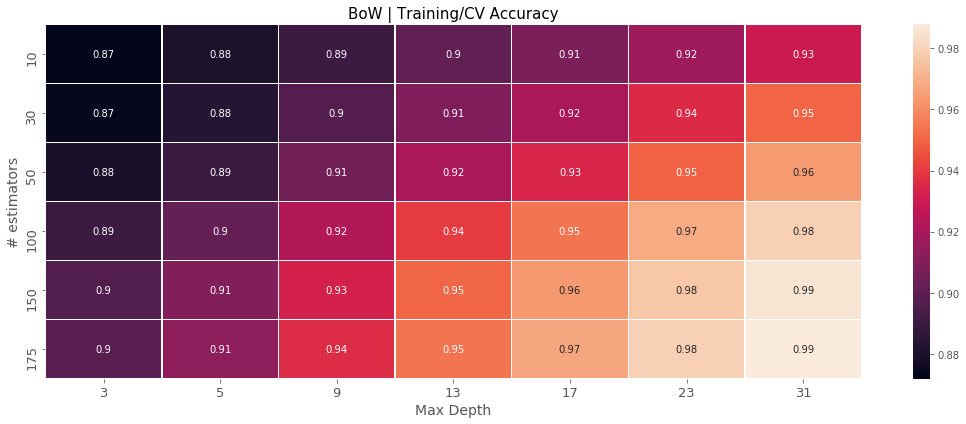

In [21]:
heatmap(n_depth_score(clf.cv_results_), vector_type='BoW', style = 'ggplot')

Import prettytable to summarize the results in a table

In [22]:
from prettytable import PrettyTable
table = PrettyTable()

**Ratios | BoW**

In [23]:
%%notify

cm_bow_train, cm_bow_test = give_me_ratios(X_train_transformed_bow_std, y_train, X_test_transformed_bow_std, y_test, 'Bag of Words', table, clf, clf.best_params_['n_estimators'],clf.best_params_['max_depth'])

+--------------+----------+-------------------+----------------+-----------+--------+------+------+------+--------------------+
| Vector Type  | Data Set | Best n_estimators | Best max_depth | Precision | Recall | TNR  | FPR  | FNR  |      Accuracy      |
+--------------+----------+-------------------+----------------+-----------+--------+------+------+------+--------------------+
| Bag of Words |  Train   |        175        |       31       |    0.98   |  1.0   | 0.91 | 0.09 | 0.0  | 0.9839086141087954 |
| Bag of Words |   Test   |        175        |       31       |    0.92   |  0.98  | 0.57 | 0.43 | 0.02 | 0.9103590306857967 |
+--------------+----------+-------------------+----------------+-----------+--------+------+------+------+--------------------+


<IPython.core.display.Javascript object>

**Confusion Matrix | BoW**

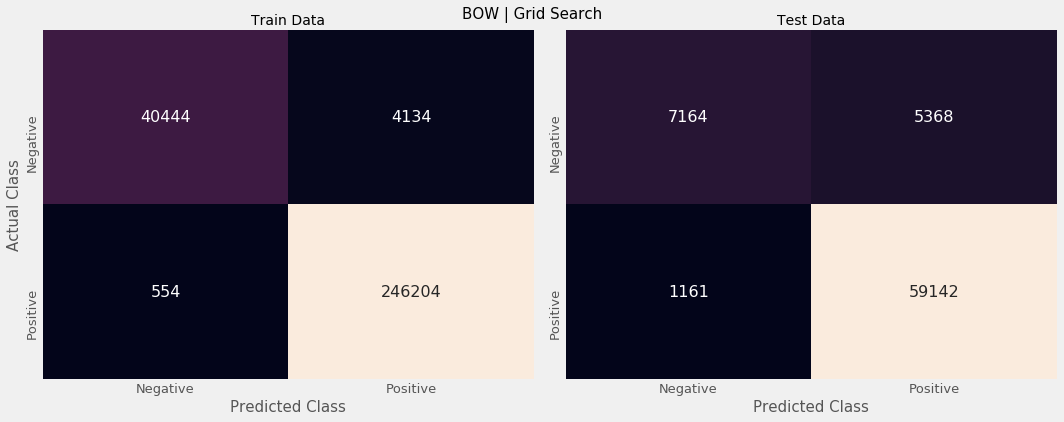

In [24]:
plot_confusion_matrix(cm_bow_train, cm_bow_test, title="BOW | Grid Search")

## Tfidf

In this section, we'll apply GBDTs on reviews represented in the Tfidf format. Load the transformed train and test sets.

In [25]:
# f = open(r'D:\data_science\datasets\amazon2\X_train_transformed_tfidf_full_nparray.pkl', 'rb')
f = open('/home/ucanreachtvk/data/X_train_transformed_tfidf_full_nparray.pkl', 'rb')
X_train_transformed_tfidf = pickle.load(f)
f.close()
print('The datatype of X_train_transformed_tfidf is : {}'.format(type(X_train_transformed_tfidf)))
print('The shape of X_train_transformed_tfidf is : {}'.format(X_train_transformed_tfidf.shape))

The datatype of X_train_transformed_tfidf is : <class 'scipy.sparse.csr.csr_matrix'>
The shape of X_train_transformed_tfidf is : (291336, 64221)


In [26]:
# f = open(r'D:\data_science\datasets\amazon2\X_test_transformed_tfidf_full_nparray.pkl', 'rb')
f = open('/home/ucanreachtvk/data/X_test_transformed_tfidf_full_nparray.pkl', 'rb')
X_test_transformed_tfidf = pickle.load(f)
f.close()
print('The datatype of X_test_transformed_tfidf is : {}'.format(type(X_test_transformed_tfidf)))
print('The shape of X_test_transformed_tfidf is : {}'.format(X_test_transformed_tfidf.shape))

The datatype of X_test_transformed_tfidf is : <class 'scipy.sparse.csr.csr_matrix'>
The shape of X_test_transformed_tfidf is : (72835, 64221)


Standardize data

In [27]:
scaler = StandardScaler(with_mean = False)
X_train_transformed_tfidf_std = scaler.fit_transform(X_train_transformed_tfidf)

In [28]:
X_test_transformed_tfidf_std = scaler.transform(X_test_transformed_tfidf)

**GridSearch | TFIDF **

In [29]:
clf = GridSearch(X_train_transformed_tfidf_std)

Train the model

In [ ]:
%%notify
%%time

clf.fit(X_train_transformed_tfidf_std, y_train)

**Score Heatmap | Tfidf**

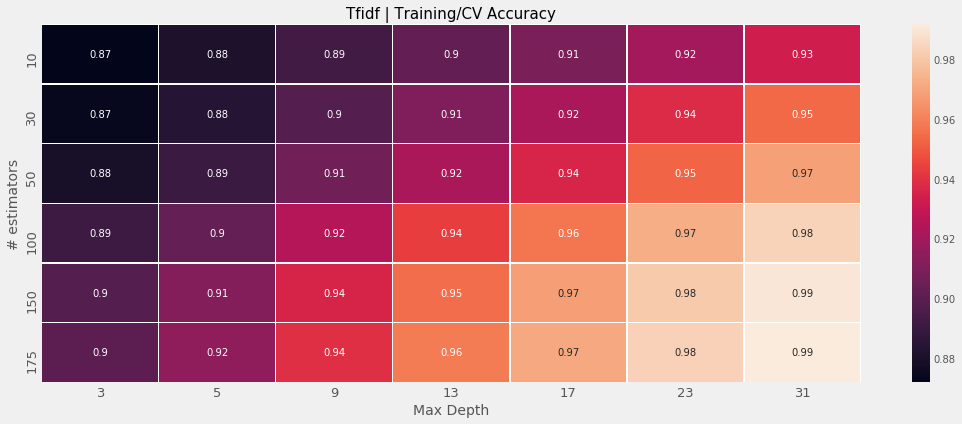

In [31]:
heatmap(n_depth_score(clf.cv_results_), vector_type='Tfidf', style = 'ggplot')

**Ratios | Tfidf**

In [32]:
%%notify

cm_tfidf_train, cm_tfidf_test = give_me_ratios(X_train_transformed_tfidf_std, y_train, X_test_transformed_tfidf_std, y_test, 'Tfidf', table, clf, clf.best_params_['n_estimators'],clf.best_params_['max_depth'])

+--------------+----------+-------------------+----------------+-----------+--------+------+------+------+--------------------+
| Vector Type  | Data Set | Best n_estimators | Best max_depth | Precision | Recall | TNR  | FPR  | FNR  |      Accuracy      |
+--------------+----------+-------------------+----------------+-----------+--------+------+------+------+--------------------+
| Bag of Words |  Train   |        175        |       31       |    0.98   |  1.0   | 0.91 | 0.09 | 0.0  | 0.9839086141087954 |
| Bag of Words |   Test   |        175        |       31       |    0.92   |  0.98  | 0.57 | 0.43 | 0.02 | 0.9103590306857967 |
|    Tfidf     |  Train   |        175        |       31       |    0.99   |  1.0   | 0.93 | 0.07 | 0.0  | 0.9886591427080759 |
|    Tfidf     |   Test   |        175        |       31       |    0.92   |  0.98  | 0.56 | 0.44 | 0.02 | 0.9088624974256883 |
+--------------+----------+-------------------+----------------+-----------+--------+------+------+-----

<IPython.core.display.Javascript object>

**Confusion Matrix | Tfidf**

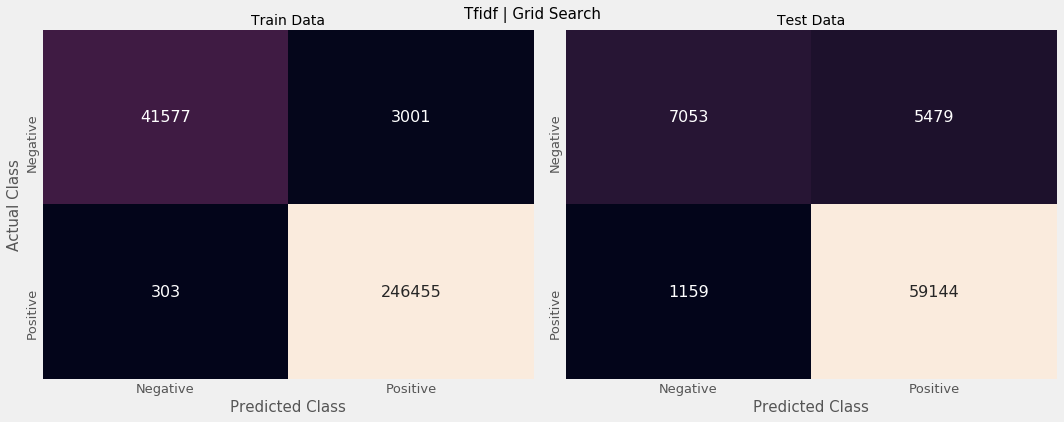

In [33]:
plot_confusion_matrix(cm_tfidf_train, cm_tfidf_test, title="Tfidf | Grid Search")

## Avg W2V

In this section, we'll apply GBDT on data represented in the avg. W2V format.
load the train and test data stored on disk.

In [34]:
# f = open(r'D:\data_science\datasets\amazon2\X_train_transformed_avgW2V_full80_20_nparray.pkl', 'rb')
f = open('/home/ucanreachtvk/data/X_train_transformed_avgW2V_full80_20_nparray.pkl', 'rb')
X_train_transformed_avgW2V = pickle.load(f)
f.close()
print('The datatype of X_train_transformed_avgW2V is : {}'.format(type(X_train_transformed_avgW2V)))
print('The shape of X_train_transformed_avgW2V is : {}'.format(X_train_transformed_avgW2V.shape))

The datatype of X_train_transformed_avgW2V is : <class 'numpy.ndarray'>
The shape of X_train_transformed_avgW2V is : (291336, 50)


In [35]:
# f = open(r'D:\data_science\datasets\amazon2\X_test_transformed_avgW2V_full80_20_nparray.pkl', 'rb')
f = open('/home/ucanreachtvk/data/X_test_transformed_avgW2V_full80_20_nparray.pkl', 'rb')
X_test_transformed_avgW2V = pickle.load(f)
f.close()
print('The datatype of X_test_transformed_avgW2V is : {}'.format(type(X_test_transformed_avgW2V)))
print('The shape of X_test_transformed_avgW2V is : {}'.format(X_test_transformed_avgW2V.shape))

The datatype of X_test_transformed_avgW2V is : <class 'numpy.ndarray'>
The shape of X_test_transformed_avgW2V is : (72835, 50)


**Standardize the data**

In [36]:
scaler = StandardScaler(with_mean = True)
X_train_transformed_avgW2V_std = scaler.fit_transform(X_train_transformed_avgW2V)

In [37]:
X_test_transformed_avgW2V_std = scaler.transform(X_test_transformed_avgW2V)

**GridSearch | avg. W2V **



In [38]:
clf = GridSearch(X_train_transformed_avgW2V_std)

In [ ]:
%%notify
%%time

clf.fit(X_train_transformed_avgW2V_std, y_train)

**Score Heatmap | Avg. W2V**

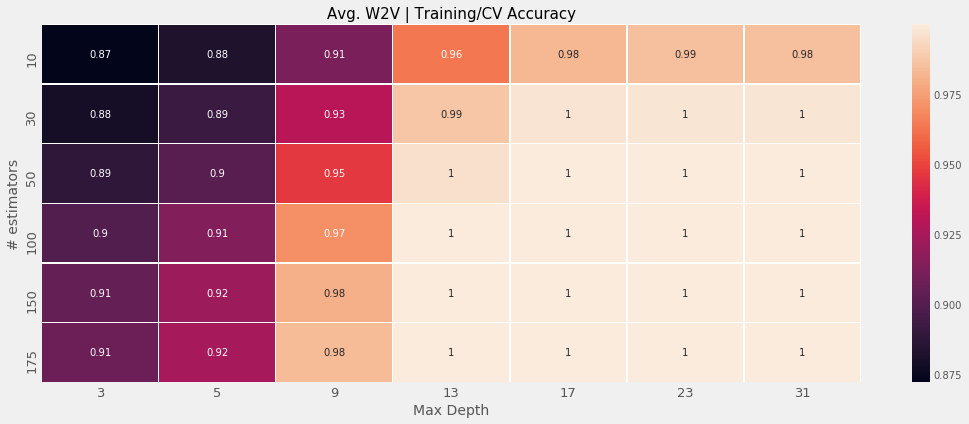

In [40]:
heatmap(n_depth_score(clf.cv_results_), vector_type='Avg. W2V', style = 'ggplot')

**Ratios | Avg. W2V**

In [41]:
%%notify

cm_w2v_train, cm_w2v_test = give_me_ratios(X_train_transformed_avgW2V_std, y_train, X_test_transformed_avgW2V_std, y_test, 'Avg. W2V', table, clf, clf.best_params_['n_estimators'],clf.best_params_['max_depth'])

+--------------+----------+-------------------+----------------+-----------+--------+------+------+------+--------------------+
| Vector Type  | Data Set | Best n_estimators | Best max_depth | Precision | Recall | TNR  | FPR  | FNR  |      Accuracy      |
+--------------+----------+-------------------+----------------+-----------+--------+------+------+------+--------------------+
| Bag of Words |  Train   |        175        |       31       |    0.98   |  1.0   | 0.91 | 0.09 | 0.0  | 0.9839086141087954 |
| Bag of Words |   Test   |        175        |       31       |    0.92   |  0.98  | 0.57 | 0.43 | 0.02 | 0.9103590306857967 |
|    Tfidf     |  Train   |        175        |       31       |    0.99   |  1.0   | 0.93 | 0.07 | 0.0  | 0.9886591427080759 |
|    Tfidf     |   Test   |        175        |       31       |    0.92   |  0.98  | 0.56 | 0.44 | 0.02 | 0.9088624974256883 |
|   Avg. W2V   |  Train   |        175        |       9        |    0.97   |  0.99  | 0.81 | 0.19 | 0.01

<IPython.core.display.Javascript object>

**Confusion Matrix | Avg. W2V**

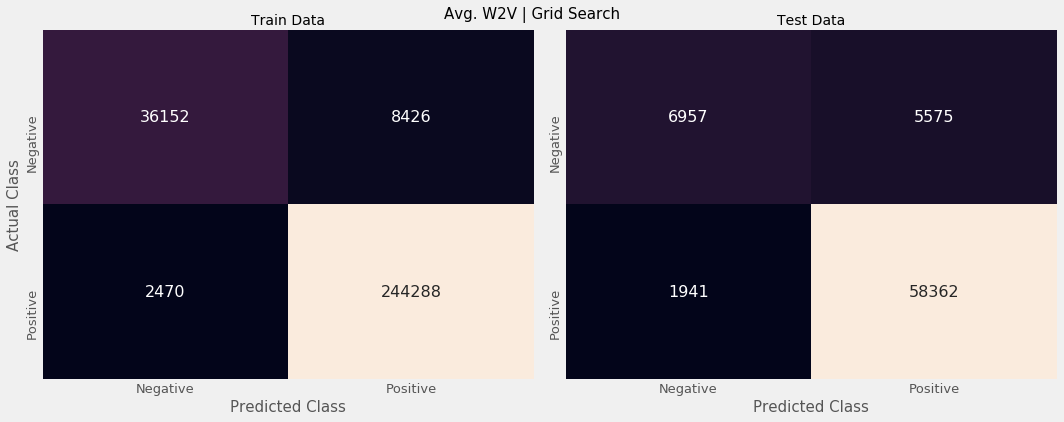

In [42]:
plot_confusion_matrix(cm_w2v_train, cm_w2v_test, title="Avg. W2V | Grid Search")

## Tfidf weighted W2V

In this last section, we apply GBDT on vectors represented in the form of Tfidf weighted W2V.

In [43]:
# f = open(r'D:\data_science\datasets\amazon2\X_train_transformed_TfidfWeightedW2V_full80_20_nparray.pkl', 'rb')
f = open('/home/ucanreachtvk/data/X_train_transformed_TfidfWeightedW2V_full80_20_nparray.pkl', 'rb')
X_train_transformed_TfidfW2V = pickle.load(f)
f.close()
print('The datatype of X_train_transformed_TfidfW2V is : {}'.format(type(X_train_transformed_TfidfW2V)))
print('The shape of X_train_transformed_TfidfW2V is : {}'.format(X_train_transformed_TfidfW2V.shape))

The datatype of X_train_transformed_TfidfW2V is : <class 'numpy.ndarray'>
The shape of X_train_transformed_TfidfW2V is : (291336, 50)


In [44]:
# f = open(r'D:\data_science\datasets\amazon2\X_test_transformed_TfidfWeightedW2V_full80_20_nparray.pkl', 'rb')
f = open('/home/ucanreachtvk/data/X_test_transformed_TfidfWeightedW2V_full80_20_nparray.pkl', 'rb')
X_test_transformed_TfidfW2V = pickle.load(f)
f.close()
print('The datatype of X_test_transformed_TfidfW2V is : {}'.format(type(X_test_transformed_TfidfW2V)))
print('The shape of X_train_transformed_TfidfW2V is : {}'.format(X_test_transformed_TfidfW2V.shape))

The datatype of X_test_transformed_TfidfW2V is : <class 'numpy.ndarray'>
The shape of X_train_transformed_TfidfW2V is : (72835, 50)


Standardize data

In [45]:
scaler = StandardScaler(with_mean = True)
X_train_transformed_TfidfW2V_std = scaler.fit_transform(X_train_transformed_TfidfW2V)

In [46]:
X_test_transformed_TfidfW2V_std = scaler.transform(X_test_transformed_TfidfW2V)

**GridSearch | Tfidf Weighted W2V**

In [47]:
clf = GridSearch(X_train_transformed_TfidfW2V_std)

In [ ]:
%%notify
%%time

clf.fit(X_train_transformed_TfidfW2V_std, y_train)

**Score Heatmap | Tfidf wt. W2V**

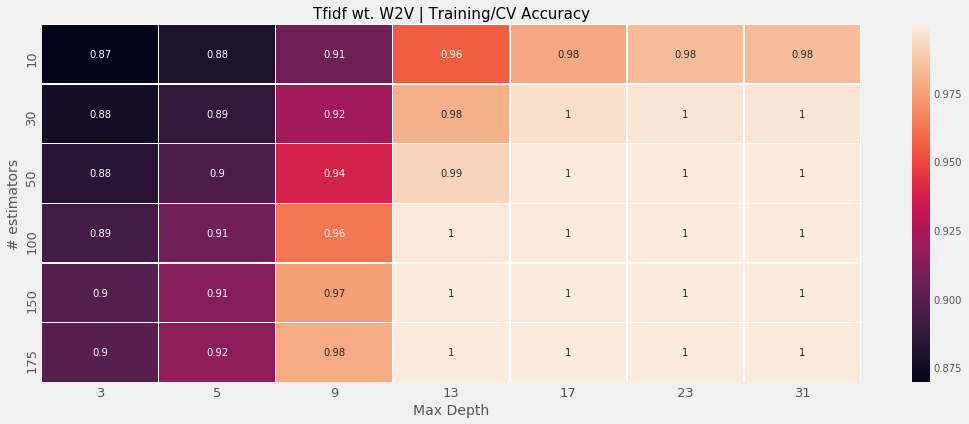

In [49]:
heatmap(n_depth_score(clf.cv_results_), vector_type='Tfidf wt. W2V', style = 'ggplot')

**Ratios | Tfidf wt. W2V**

In [50]:
cm_tfidfw2v_train, cm_tfidfw2v_test = give_me_ratios(X_train_transformed_TfidfW2V_std, y_train, X_test_transformed_TfidfW2V_std, y_test, 'Tfidf wt. W2V', table, clf, clf.best_params_['n_estimators'],clf.best_params_['max_depth'])

+---------------+----------+-------------------+----------------+-----------+--------+------+------+------+--------------------+
|  Vector Type  | Data Set | Best n_estimators | Best max_depth | Precision | Recall | TNR  | FPR  | FNR  |      Accuracy      |
+---------------+----------+-------------------+----------------+-----------+--------+------+------+------+--------------------+
|  Bag of Words |  Train   |        175        |       31       |    0.98   |  1.0   | 0.91 | 0.09 | 0.0  | 0.9839086141087954 |
|  Bag of Words |   Test   |        175        |       31       |    0.92   |  0.98  | 0.57 | 0.43 | 0.02 | 0.9103590306857967 |
|     Tfidf     |  Train   |        175        |       31       |    0.99   |  1.0   | 0.93 | 0.07 | 0.0  | 0.9886591427080759 |
|     Tfidf     |   Test   |        175        |       31       |    0.92   |  0.98  | 0.56 | 0.44 | 0.02 | 0.9088624974256883 |
|    Avg. W2V   |  Train   |        175        |       9        |    0.97   |  0.99  | 0.81 | 0.1

**Confusion Matrix | Tfidf wt. W2V**

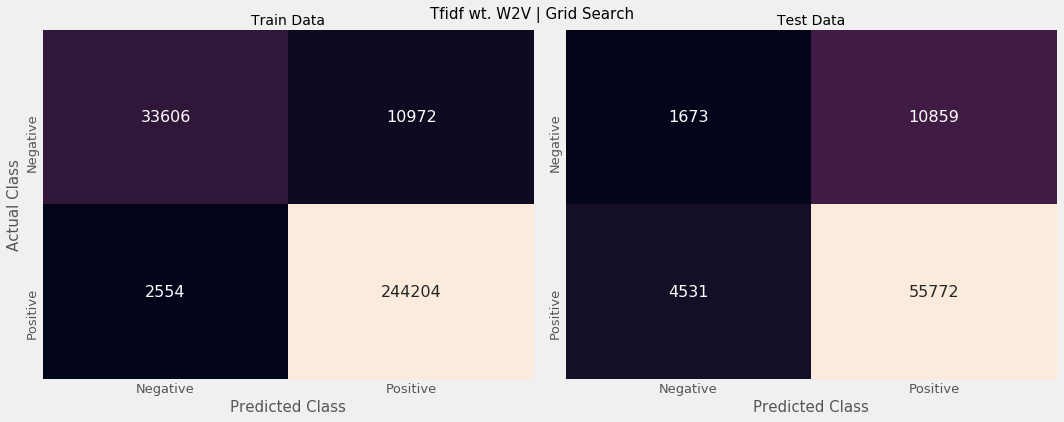

In [51]:
plot_confusion_matrix(cm_tfidfw2v_train, cm_tfidfw2v_test, title="Tfidf wt. W2V | Grid Search")

### Conclusion:

* We applied Gradient Boosted Decision Trees classifier on amazon food reviews for various vector representations.
* Observed that genearlly, more the number of estimators and depth, better the results.
* Plotted the confusion matrix for train and test data and also calculated several important ratios based on it such as Precision, Recall, FNR, etc.
